### Git versioning

In [1]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources
openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-core').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "Openfisca-france-data :", git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Aggregates :", git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Survey-Manager :", git.Repo(pkg_resources.get_distribution('OpenFisca-Survey-Manager').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]

---This notebook have been runed with--- 
Openfisca-france : f710f63abb52a3395a126bd96e0f3f4bfd83d1a6 

Commit short SHA: f710
Branch:  mensualisation_wip
Date (y/m/d): 2016-07-26 13:55:47  

Openfisca-core : 4076f591f4bcb571391b65a989e1603fdc4cb759  Date: 2016-02-24 16:11:57 
Openfisca-france-data : a6b02e6909ee9c27169cd5cf73c51df9b1640ef9  Date: 2016-05-31 15:54:47 
OpenFisca-Aggregates : fd210d8cfdf6ed68f173d9d5c3eab4a4302ed2b9  Date: 2016-04-04 11:35:03 
OpenFisca-Survey-Manager : 868512d24307aa75cfa7bbbf8420542960963966  Date: 2016-04-04 11:35:03 


### Imports

In [2]:
%matplotlib inline
from __future__ import division

import calendar

from openfisca_core import periods
from openfisca_plugin_aggregates.tests.reform.test_aggregates_mensualized import create_survey_scenario
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


import numpy as np
from numpy import (datetime64, logical_and as and_, logical_not as not_, logical_or as or_, logical_xor as xor_,
maximum as max_, minimum as min_, round)


#Faire des filtres pour Mahdi survey_scenario.create_data_frame_by_entity_key_plural

pd.set_option('expand_frame_repr', False)  #utile quand on utilise pandas en mode console
pd.set_option("display.max_rows",201)
pd.set_option("display.max_columns",201)

/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


# Create Survey Scenario

In [3]:
period = periods.period(2009)

In [4]:
period.this_year.this_month

Period((u'month', Instant((2009, 1, 1)), 1))

In [5]:
survey_scenario = create_survey_scenario(2009)
survey_scenario.new_simulation()


simulation = survey_scenario.simulation
scenario = survey_scenario

weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)
print weight_foyers.shape, weight_menages.shape, weight_familles.shape, weight_individus.shape

(52189,) (42709,) (48195,) (80431,)


In [6]:
def sum_by_entity(var, entity_key, roles = None):
    var_holder = simulation.compute_add(var)
    entity = simulation.entity_by_key_singular[entity_key]
    
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += var_holder.array[boolean_filter]
    return target_array



def sum_array_by_entity(array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
    return target_array
    

def cast_from_entity_to_role( var , roles = None):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = simulation.compute_add(var).array[entity_index_array[boolean_filter]]
    return target_array

def cast_array_from_entity_to_role( array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = array[entity_index_array[boolean_filter]]
    return target_array


def switch_entity(var, target_entity  ,roles = [0]):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    
    target_array = cast_from_entity_to_role(var, roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array

def switch_array_entity(array,entity, target_entity  ,roles = [0]):
    
    entity = entity
    
    target_array = cast_array_from_entity_to_role(array, entity,roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array


In [7]:
#pd.value_counts(switch_array_entity(revdisp_negatif, 'menage',"foyer_fiscal", roles = range(10)))

In [8]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]
        
        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = 'int64')
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
            target_array_by_role[role] = array[boolean_filter]
        return target_array_by_role

In [9]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]

        assert not entity.is_persons_entity

        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            # To ensure that existing formulas don't fail, ensure there is always at least 11 roles.
            # roles = range(entity.roles_count)
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = array.dtype)
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
        return target_array_by_role


In [10]:
    def uc(entity):
        '''
        Calcule le nombre d'unités de consommation du ménage avec l'échelle de l'insee
        'men'
        '''


        age_en_mois = split_by_roles("age_en_mois", entity)

        uc_adt = 0.5
        uc_enf = 0.3
        uc = 0.5
        for agm in age_en_mois.itervalues():
            age = np.floor(agm / 12)
            adt = (15 <= age) & (age <= 150)
            enf = (0 <= age) & (age <= 14)
            uc += adt * uc_adt + enf * uc_enf
        return uc


In [11]:
uc_famille =  uc('famille')
uc_menage = uc('menage')

In [12]:
uc_famille.shape

(48195,)

In [13]:
weight_familles.shape

(48195,)

In [14]:
rev_disp_uc = simulation.calculate_add('revdisp_mensuel_annuel')/uc_menage

In [15]:
sum_by_entity("salaire_net", 'foyer_fiscal')
cast_from_entity_to_role('decote')
switch_entity('irpp', 'famille')

array([    0.       ,     0.       ,     0.       , ..., -1824.6550293,
           0.       ,     0.       ])

In [16]:
revdisp_negatif = (rev_disp_uc < 0)

In [17]:
pd.value_counts(revdisp_negatif)

False    42709
dtype: int64

In [18]:
pd.value_counts(simulation.calculate_add('rev_trav')<0)

False    80191
True       240
dtype: int64

In [19]:
simulation.persons.count

80431

In [20]:
hello = simulation.entity_by_key_singular["menage"]

In [21]:
simulation.holder_by_name[hello.index_for_person_variable_name].array

array([    0,     0,     0, ..., 22229, 39367,  5598], dtype=int32)

In [22]:
survey_scenario.compute_aggregate("irpp")/10**9

-45.916198083041756

## Share of more than 20% variation per decile

In [23]:
import pandas as pd


In [24]:
income_month_list = ["income_month_{}".format(month) for month in range(1,13)]

In [25]:
df = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df["income_month_{}".format(month)] = month_income

In [26]:
df["yearly_income"] = df[income_month_list].sum(1)
df["diff_rev"] = df[income_month_list].max(1) - df[income_month_list].min(1)
df["relative_var"] = (df[income_month_list].max(1) - df[income_month_list].min(1))/df[income_month_list].max(1)

In [27]:
has_rev_filter = df["yearly_income"]>1

In [28]:
print df["diff_rev"].mean()
print df["diff_rev"][has_rev_filter].mean()

315.795882838
392.298808459


In [29]:
df[has_rev_filter & (df.diff_rev <2000)].shape[0]/df[has_rev_filter].shape[0]

0.9564760757421308

In [30]:
%%time
range_to_use = range(1,7000,20)
income_rep_func =[df[has_rev_filter & (df.diff_rev<income)].shape[0]/df[has_rev_filter].shape[0] for income in range_to_use]

CPU times: user 3.88 s, sys: 1.75 s, total: 5.62 s
Wall time: 5.96 s


In [31]:
income_rep_func

[0.8603774750563742,
 0.8614586229265129,
 0.862292651283477,
 0.8633583541840423,
 0.8644858369629012,
 0.8652735304111451,
 0.8663701232508572,
 0.8675902758471565,
 0.8686096438390016,
 0.869567231952553,
 0.8705711549748247,
 0.8716831927841102,
 0.872918790349983,
 0.8742933926420164,
 0.8755135452383159,
 0.8767800327433355,
 0.8779229604917679,
 0.8792357829055076,
 0.8805022704105273,
 0.8818305377938406,
 0.88305069039014,
 0.8841009483211318,
 0.8850430914651098,
 0.8864331387267167,
 0.8873135019924011,
 0.8885954344669941,
 0.8897846971241467,
 0.8907268402681247,
 0.8921168875297316,
 0.8933061501868841,
 0.8942482933308621,
 0.895715565440336,
 0.897105612701943,
 0.8984338800852563,
 0.8996231427424088,
 0.9010131900040157,
 0.9022333426003151,
 0.9032990455008804,
 0.9043184134927255,
 0.9053532264541438,
 0.9066969388070305,
 0.9078089766163161,
 0.9088437895777345,
 0.9101102770827542,
 0.9111759799833195,
 0.9122725728230315,
 0.9133537206931702,
 0.914512093411176,


In [32]:
df_m = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_m["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'menage')
    
df_m["yearly_income"] = df_m[income_month_list].sum(1)
df_m["diff_rev"] = df_m[income_month_list].max(1) - df_m[income_month_list].min(1)
df_m["relative_var"] = (df_m[income_month_list].max(1) - df_m[income_month_list].min(1))/df_m[income_month_list].max(1)

has_rev_filter_m = df_m["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_m =[df_m[has_rev_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_filter_m].shape[0] for income in range_to_use]

In [33]:
df_f = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_f["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'foyer_fiscal')
    
df_f["yearly_income"] = df_f[income_month_list].sum(1)
df_f["diff_rev"] = df_f[income_month_list].max(1) - df_f[income_month_list].min(1)
df_f["relative_var"] = (df_f[income_month_list].max(1) - df_f[income_month_list].min(1))/df_f[income_month_list].max(1)


has_rev_filter_f = df_f["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_f =[df_f[has_rev_filter_f & (df_f.diff_rev<income)].shape[0]/df_f[has_rev_filter_f].shape[0] for income in range_to_use]

In [34]:
df_f.shape

(52189, 15)

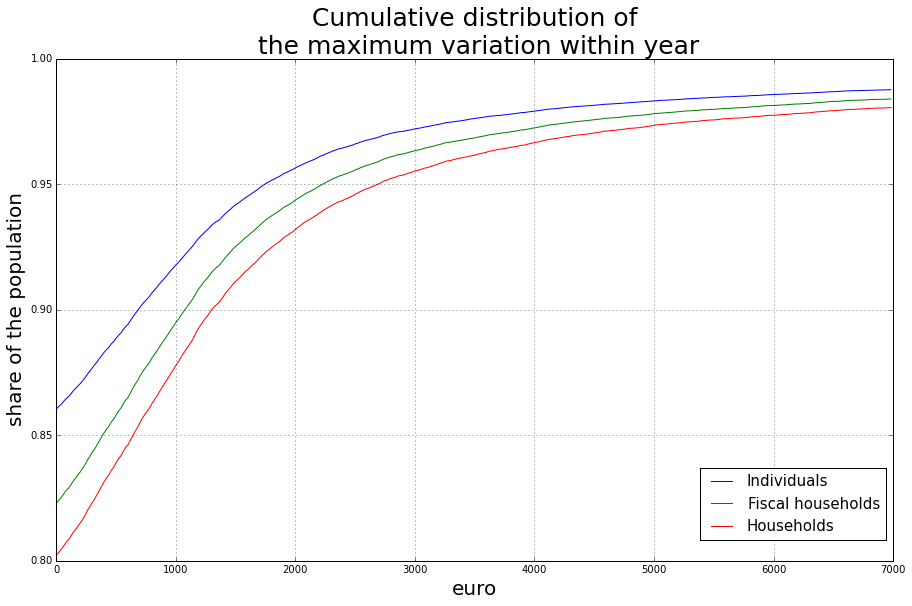

In [35]:

plt.figure(figsize=(15,9))
plt.plot(range_to_use,income_rep_func,label = 'Individuals')
plt.plot(range_to_use,income_rep_func_f,label = 'Fiscal households')
plt.plot(range_to_use,income_rep_func_m,label = 'Households')


plt.ylabel("share of the population", fontsize=20 )
plt.xlabel("euro", fontsize=20)
plt.title('Cumulative distribution of \n the maximum variation within year', fontsize = 25)

plt.legend(bbox_to_anchor=(1, 0.2), fontsize=15)
plt.grid()
plt.figure(figsize = (10,20))

### Cumulative only for those with a unique income for each month (with no null income)

In [36]:
revenu_diff_0_per_month = np.zeros(weight_individus.shape)
for var in ['salaire_imposable', 'chomage_imposable', 'retraite_imposable']:
    for month in range(1,13):
        revenu_diff_0_per_month += pd.Series(simulation.calculate('{}'.format(var), '2009-{}'.format(month))) != 0 

In [37]:
unique_income = (revenu_diff_0_per_month == 12)

In [38]:
filter_rev_but_not_unique = (pd.Series(has_rev_filter) & (~ pd.Series(unique_income)))

In [39]:
un_seul_revenu_m = sum_array_by_entity(month_income, 'menage')

In [40]:
has_rev_unic_each_month_filter = (df["yearly_income"]>1) & unique_income
has_rev_unic_each_month_filter_m = sum_array_by_entity(filter_rev_but_not_unique, 'menage')
has_rev_unic_each_month_filter_m = ~ has_rev_unic_each_month_filter_m.astype('bool')

In [41]:
has_rev_unic_each_month_filter_f = sum_array_by_entity(filter_rev_but_not_unique, 'foyer_fiscal')
has_rev_unic_each_month_filter_f = ~ has_rev_unic_each_month_filter_f.astype('bool')

In [42]:
%%time
range_to_use = range(1,7000,20)
income_rep_func_unique_m =[df_m[has_rev_unic_each_month_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_unic_each_month_filter_m].shape[0] for income in range_to_use]


CPU times: user 2.37 s, sys: 63.7 ms, total: 2.44 s
Wall time: 3.57 s


In [43]:

range_to_use = range(1,7000,20)
income_rep_func_unique_f =[df_f[has_rev_unic_each_month_filter_f & (df_f.diff_rev<income)].shape[0]/df_f[has_rev_unic_each_month_filter_f].shape[0] 
                           for income in range_to_use]


In [44]:
%%time
range_to_use = range(1,7000,20)
income_rep_func_unique =[df[has_rev_unic_each_month_filter & (df.diff_rev<income)].shape[0]/df[has_rev_unic_each_month_filter].shape[0]
                         for income in range_to_use]


CPU times: user 6.51 s, sys: 2.19 s, total: 8.7 s
Wall time: 10.8 s


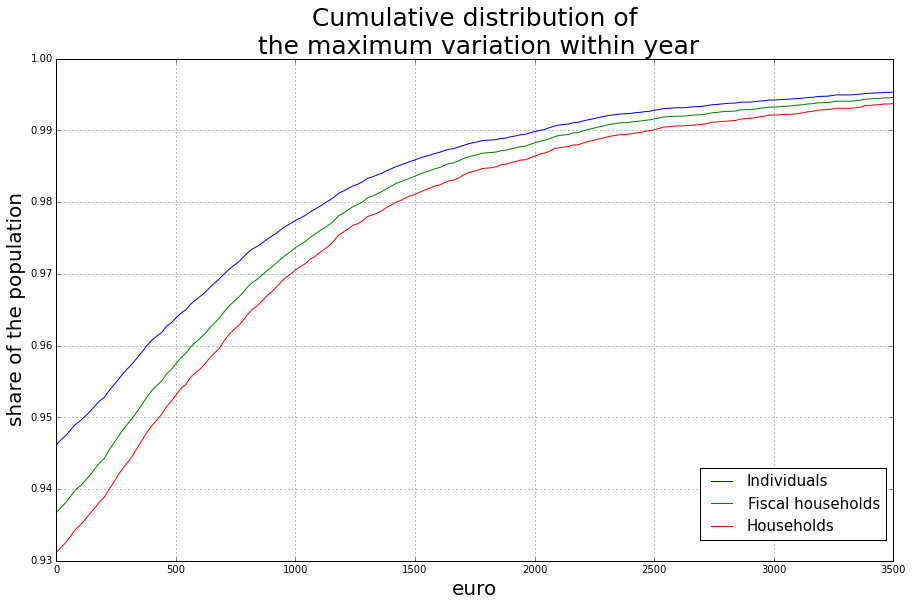

In [45]:

plt.figure(figsize=(15,9))
plt.plot(range_to_use,income_rep_func_unique,label = 'Individuals')
plt.plot(range_to_use,income_rep_func_unique_f,label = 'Fiscal households')
plt.plot(range_to_use,income_rep_func_unique_m,label = 'Households')


plt.ylabel("share of the population", fontsize=20 )
plt.xlabel("euro", fontsize=20)
plt.title('Cumulative distribution of \n the maximum variation within year', fontsize = 25)
plt.xlim((0,3500))

plt.legend(bbox_to_anchor=(1, 0.2), fontsize=15)
plt.grid()
plt.figure(figsize = (10,20))


In [46]:
filter_neg.value_counts()

NameError: name 'filter_neg' is not defined

In [ ]:
unique_income_with_rev = has_rev_filter & unique_income

In [ ]:
pd.Series(has_rev_filter).value_counts()

In [ ]:
has_rev_filter.shape

In [ ]:
df_m = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.calculate("revdisp_mensuel_annuel","2009-01").shape[0])
    month_income += simulation.calculate("revdisp_mensuel_annuel","2009-{}".format(month))
    df_m["income_month_{}".format(month)] = month_income
    
df_m["yearly_income"] = df_f[income_month_list].sum(1)
df_m["diff_rev"] = df_f[income_month_list].max(1) - df_f[income_month_list].min(1)
df_m["relative_var"] = (df_m[income_month_list].max(1) - df_m[income_month_list].min(1))/df_m[income_month_list].max(1)


has_rev_filter_m = df_m["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_m =[df_m[has_rev_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_filter_m].shape[0] for income in range_to_use]

In [ ]:

plt.figure(figsize=(15,9))

plt.plot(range_to_use,income_rep_func_m,label = 'Households')


plt.ylabel("share of the population", fontsize=20 )
plt.xlabel("euro", fontsize=20)
plt.title('Cumulative distribution of \n the maximum variation within year after tax and transfers', fontsize = 25)

plt.legend(bbox_to_anchor=(1, 0.2), fontsize=15)
plt.grid()
plt.xlim(0,1000)
plt.figure(figsize = (10,20))


In [ ]:
print (pd.Series(simulation.calculate('salaire_imposable'))[(df["diff_rev"]>1000)]>0).value_counts()
print (pd.Series(simulation.calculate('retraite_imposable'))[(df["diff_rev"]>1000)]>0).value_counts()
print (pd.Series(simulation.calculate('chomage_imposable'))[(df["diff_rev"]>1000)]>0).value_counts()

In [ ]:
pd.Series(simulation.calculate('retraite_imposable')).value_counts()

In [ ]:

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df['revenu_mois{}'.format(month)] = month_income

In [ ]:
del month_income

In [ ]:
df[(df["diff_rev"]>5000)].head()

In [ ]:
count,division = np.histogram(df[(df.yearly_income>0)].yearly_income,bins=10)
bins = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))

In [ ]:
#### Marginal rates
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
test_case_simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = test_case_simulation.calculate('rbg')
irpp_test_case = test_case_simulation.calculate('irpp')
revdisp_test_case = test_case_simulation.calculate('revdisp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
global_marginal_rate = rates.marginal_rate(revdisp_test_case, rbg_test_case)
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]

#Average
global_average_rate = rates.average_rate(revdisp_test_case[76:] - revdisp_test_case[0], rbg_test_case[76:])
average_rate = rates.average_rate(irpp_test_case[76:] , rbg_test_case[76:])

In [ ]:
rbg_test_case[:48]

In [ ]:
plt.plot( rbg_test_case[::10], global_marginal_rate[::10])
plt.plot(rbg_test_case[::10], marginal_rate[::10])
plt.plot(rbg_test_case[76:], global_average_rate, '--b')
plt.plot(rbg_test_case[76:], average_rate-1, '--r')
plt.ylim(-1,1)
plt.xlim(0,50000)

In [ ]:
plt.plot(rbg_test_case[76:], average_rate, '--r')

In [ ]:
survey_scenario.simulation.calculate("rbg")

In [ ]:
income_by_fisal_shares = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))  
                                                           
df_m["income_by_fiscalshares"] =  switch_array_entity(income_by_fisal_shares,  "foyer_fiscal", "menage")  #income_by_fiscal_shares
df_f.shape
                                                                     
                              

In [ ]:
plt.hist(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"), bins = 1000)
plt.xlim(0,20000)

In [ ]:
plt.figure(figsize=(10,5))
ax = df_m.income_by_fiscalshares.hist(bins =1000, alpha = 0.2, color = 'k')

ax2 = ax.twinx()
#ax2.plot( rbg_test_case[::35], global_marginal_rate[::35])
ax2.plot( rbg_test_case[::15], global_marginal_rate[::15], '-b',label = "Piecewize linear tax scheme")
ax2.plot(rbg_test_case[::10], marginal_rate[::10],  '-g',label = "Effective marginal tax rates")
ax2.plot(rbg_test_case[76:], global_average_rate, '--b', label = "Average rate from tax scheme")
ax2.plot(rbg_test_case[76:], average_rate-1, '--g', label = "Effective average tax rates")
ax2.legend(loc = 1)
plt.xlim(0,120000)
ax.set_ylabel('Number of households', fontsize=15)
ax.set_xlabel('Household income by fiscal share \n (in euros)', fontsize=15)
ax2.set_ylabel('Marginal rate', fontsize=15)
ax2.set_ylim(0,1)

In [ ]:
simulation.calculate('rbg_mensuel_times_12', '2009-01')

In [ ]:
rbg_month_by_fs_list = ["rbg_month_by_fs_{}".format(month) for month in range(1,13)]
df_m = pd.DataFrame()

for month in range(1,13):
    month_rbg = np.zeros(52189)
    for var in ['rni_mensuel_times_12']:
        month_rbg += (simulation.calculate(var,"2009-{}".format(month))/12)
    df_m["rbg_month_by_fs_{}".format(month)] = switch_array_entity(month_rbg, 'foyer_fiscal','menage')/switch_entity('nbptr', 'menage')
    

df_m["yearly_rbg_by_fs"] = df_m[rbg_month_by_fs_list].sum(1)
df_m["diff_rbg"] = df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1)
df_m["rbg_relative_var"] = (df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1))/df_m[rbg_month_by_fs_list].max(1)

has_rbg_filter_m = df_m["yearly_rbg_by_fs"]>1

range_to_use = range(1,7000,20)

In [ ]:
rbg_month_by_fs_list = ["rbg_month_by_fs_{}".format(month) for month in range(1,13)]
df_f = pd.DataFrame()

for month in range(1,13):
    month_rbg = np.zeros(52189)
    for var in ['rni_mensuel_times_12']:
        month_rbg += (simulation.calculate(var,"2009-{}".format(month))/12)
    df_f["rbg_month_by_fs_{}".format(month)] = month_rbg/simulation.calculate("nbptr")
    

df_f["yearly_rbg_by_fs"] = df_m[rbg_month_by_fs_list].sum(1)
df_f["diff_rbg"] = df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1)
df_f["rbg_relative_var"] = (df_m[rbg_month_by_fs_list].max(1) - df_m[rbg_month_by_fs_list].min(1))/df_m[rbg_month_by_fs_list].max(1)

has_rbg_filter_f = df_m["yearly_rbg_by_fs"]>1

range_to_use = range(1,7000,20)

In [ ]:
switch_entity('nbptr', 'menage')

In [ ]:
switch_array_entity(month_rbg, 'foyer_fiscal','menage').shape

In [ ]:



#TODO: vérifier que ça prend bien en compte les 10% d'abbatement, bref que rbg est bien la bonne base taxable à prendre en considération.

#(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr")

fig = plt.figure(figsize=(16, 12))


ax1 = plt.subplot2grid((2,2), (1,0), colspan=1) ; plt.figure()

rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))

n,bins,patches = plt.hist(df_m[((df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<rev_max)) & 
                             (df_m.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_rbg_by_fs>0)&(df_m.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_m[((df_m.yearly_rbg_by_fs>0)&
                                 (df_m.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax1.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax1.grid()
ax1.set_xlim([0,100000])
ax1.set_title("Households")
ax1_2 = ax1.twinx()
ax1_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax1.set_xlim(0,75000)

ax1.set_xlabel('Tax base divided by fiscal share')






ax2 = plt.subplot2grid((2,2), (0,0), colspan=2,  sharey=ax1)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<rev_max)) & 
                             (df_f.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&
                                 (df_f.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "Marginal tax rate")

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")
ax2.set_xlabel('Tax base divided by fiscal share')




ax3 = plt.subplot2grid((2,2), (1,1), colspan=1, sharey=ax1)
plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df[((df.yearly_income>0)&(df.yearly_income<rev_max)) & 
                             (df.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df[((df.yearly_income>0)&
                                 (df.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax3.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax3.grid()
ax3_2 = ax3.twinx()
ax3_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax3_2.legend()

ax3.set_xlim([0,75000])
ax3.set_title("Individuals")
ax3.set_xlabel('Tax base divided by fiscal share')

In [ ]:



#TODO: vérifier que ça prend bien en compte les 10% d'abbatement, bref que rbg est bien la bonne base taxable à prendre en considération.

#(survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr")

fig = plt.figure(figsize=(10, 7))








ax2 = plt.subplot2grid((1,1), (0,0), colspan=2)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<rev_max)) & 
                             (df_f.rbg_relative_var>0.2)].yearly_rbg_by_fs.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_rbg_by_fs>0)&(df_f.yearly_rbg_by_fs<175000)].yearly_rbg_by_fs.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_rbg_by_fs>0)&
                                 (df_f.yearly_rbg_by_fs<rev_max))].yearly_rbg_by_fs.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "Marginal tax rate")

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")
ax2.set_xlabel('Tax base divided by fiscal share')
ax2_2.legend()




### Reforme

In [ ]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)

bins= range(-100,100, 2)

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
lambda_compensation_household = switch_array_entity(lambda_compensation,'foyer_fiscal', 'menage')
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)
graph_filter_household = switch_array_entity(graph_filter, 'foyer_fiscal', 'menage').astype('bool')

fig, ax = plt.subplots(1,2,sharey = True, figsize = (15, 5), tight_layout = True)


ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))

ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))


weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = bins, weights = weights)
ax[0].set_ylim(0,0.21)
ax[0].set_xlim(-50,100)
ax[0].set_title("Fiscal Households", weight = "bold")
ax[0].set_ylabel('Share of households')
ax[0].set_xlabel('$\lambda$')
ax[0].grid(which = 'both')
ax[1].grid(which = 'both')


weights = weight_menages[graph_filter_household & ~np.isnan(lambda_compensation_household)]/sum(weight_menages[graph_filter_household& ~np.isnan(lambda_compensation_household)])
ax[1].hist(pd.Series(lambda_compensation_household[graph_filter_household]).dropna(), bins = bins, weights= weights)
ax[1].set_xlim(-50,100)

ax[1].set_xlabel('$\lambda$')
ax[1].set_title("Households", weight = "bold")



In [ ]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", 
         weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",
         weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")


In [ ]:
winners_condition = [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1]
winners = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))[winners_condition]

loosers_condition = [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1]
loosers = (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))[loosers_condition]


In [ ]:

###One euro
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")
fig.text(0.8,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
#5 euros
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>5]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-5]

fig, ax1 = plt.subplots(figsize=(20, 10))


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>5], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-5], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
legend = ax1.legend(bbox_to_anchor=(0.43, 1))
ax1.grid(which = 'both')
#ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
ax1.set_title("")
legend.get_frame().set_alpha(0.5)
ax1.set_ylim(0,300000)
fig.text(0.7,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)


###One euro
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]


bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

hist_1 = ax[0].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = bins, label = "Paying more on monthly basis", weights= weights1)
hist_2 = ax[0].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax[0].set_xlim(0,50000)
ax2 = ax[0].twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
#ax2.legend()

ax[0].grid(which = 'both')
ax[0].text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax[0].set_xlabel("Gross global income divided by fiscal shares")
ax[0].set_ylabel("number of taxunit")
ax[0].set_title("")
#fig.text(0.8,0.8,'Bin size is {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

#50 euros
weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>50]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-50]



bins = np.histogram(np.hstack((winners,loosers)), bins = 400)[1]

ax[1].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>50], bins = bins, label = "Paying more on monthly basis", weights= weights1)
ax[1].hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-50], bins = bins, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax[1].set_xlim(0,50000)
ax2 = ax[1].twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
#legend = ax[1].legend(bbox_to_anchor=(0.22, 1))
ax[1].grid(which = 'both')
#ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax[1].set_xlabel("Gross global income divided by fiscal shares")
ax[1].set_ylabel("number of taxunit")
ax[1].set_title("More thant 50 euros")
legend.get_frame().set_alpha(0.5)
ax[1].set_ylim(0,550000)

ax[0].legend(bbox_to_anchor=(0.72, -0.1), ncol = 3)
fig.text(0.038,-0.1,'Bins sizes are {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))
#fig.text(.38,-0.05,'Bins sizes are {} euros'.format(np.rint((bins[1:] - bins[:-1])).astype('int')[0]))

##  Utility analysis

In [ ]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))
u_vickrey = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_vickrey_mensuel','2009'))


In [ ]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    bins = np.histogram(np.hstack((weight_1,weight_2)), bins = 7000)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=7000,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=7000,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((u_ir_m - u_ir_a))!=0]
                                    ,(u_c_ir - u_ir_a)[((u_c_ir - u_ir_a))!=0]
            )), bins = 2000)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 14000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 700)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.002, 0.002)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    value_near_zero = 0.0000009
    weight_1 = pd.Series(weight_menages)[(np.abs((u_es_ir_m - u_es_ir_a)))>value_near_zero].values
    weight_2 = pd.Series(weight_menages)[np.abs(u_es_c_ir - u_es_ir_a)> value_near_zero].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero]
                                    ,(u_es_c_ir - u_es_ir_a)[np.abs((u_es_c_ir - u_es_ir_a))>value_near_zero]
            )), bins = 600)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[(np.abs(u_es_c_ir - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.002, 0.002)
    plt.legend()    

    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

##### Ce qui est fait pour le graph with equivalent scale : 
 - $u( \frac{\sum(y)}{ES})$ donne l'utilités d'un ménage, ou l'utilité moyenne des individus composant le ménage.
 - $u( \frac{\sum(y)}{ES})*ES $ donne l'utilité totale d'un ménage
 - et $u(\frac{\sum(y)}{ES})$ donnerait l'utilité d'un seul individu du ménage
 
###### Si on veut comparer une diff d'uilité entre deux système de taxe $u_1$ et $u_2$ : 
 - $u_1( \frac{\sum(y)}{ES}) * ES - u_2( \frac{\sum(y)}{ES}) *ES = ES [u_1( \frac{\sum(y)}{ES}) - u_2( \frac{\sum(y)}{ES})]  $ et créerai des écarts plus grand pour des ménages plus grands, alors que l'écart d'utilité moyenne serait la même.
 - Pour avoir une information individuelle, il faut prendre l'écart d'utilité pour chaque individus $u(\frac{\sum(y)}{ES})$ et multiplier le poids de l'observation par le nombre d'individus du ménage.


In [ ]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    value_near_zero = 0.0000009
    weight_1 = pd.Series(weight_menages*uc('menage'))[(np.abs((u_es_ir_m - u_es_ir_a)))>value_near_zero].values
    weight_2 = pd.Series(weight_menages*uc('menage'))[np.abs(u_es_c_ir - u_es_ir_a)> value_near_zero].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero]
                                    ,(u_es_c_ir - u_es_ir_a)[np.abs((u_es_c_ir - u_es_ir_a))>value_near_zero]
            )), bins = 600)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[(np.abs(u_es_ir_m - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[(np.abs(u_es_c_ir - u_es_ir_a))>value_near_zero].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.002, 0.002)
    plt.legend()    

    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 7000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00004, 0.00004)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 2000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00008, 0.00008)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
## Avec Echelles d'équivalences
#u_es_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel_rsa_mensuel','2009'))
u_es_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_es_compensated_ir_mensuel','2009'))
u_es_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_mensuel','2009'))
u_es_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_es_ir_annuel','2009'))

execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_es_ir_m - u_es_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_es_c_ir - u_es_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_es_ir_m - u_es_ir_a)[((u_es_ir_m - u_es_ir_a))!=0]
                                    ,(u_es_c_ir - u_es_ir_a)[((u_es_c_ir - u_es_ir_a))!=0]
            )), bins = 7000)[1]
    
    hist1 = ((u_es_ir_m - u_es_ir_a))[((u_es_ir_m - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_es_c_ir - u_es_ir_a))[((u_es_c_ir - u_es_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00008, 0.00008)
    plt.legend()
    plt.title("Difference in utility with equivalent scale w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

### Vickrey utility 

In [ ]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values
    weight_2 = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values
    weight_3 = pd.Series(weight_menages)[((u_vickrey - u_ir_a))!=0].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((u_ir_m - u_ir_a))!=0]
                                    ,(u_c_ir - u_ir_a)[((u_c_ir - u_ir_a))!=0], (u_vickrey - u_ir_a)[((u_vickrey - u_ir_a))!=0]
            )), bins = 2200)[1]
    
#    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
#                                                             weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=10, color = 'c',alpha = 0.4, label = "Compensated Monthly")
    hist3 = ((u_vickrey - u_ir_a))[((u_vickrey - u_ir_a))!=0].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_3,zorder=1, color = 'k',alpha = 1, label = "Vickrey Scheme")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,65*10**4)
    plt.xlim(-0.00001, 0.00001)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
print (((u_c_ir - u_ir_a)) < -0.0000001).value_counts()
print (((u_vickrey - u_ir_a))< -0.0000001).value_counts()
print (((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0] < -0.0000001).value_counts()
print (((u_vickrey - u_ir_a))[((u_vickrey - u_ir_a))!=0] < -0.0000001).value_counts()

In [ ]:
print 284 / (48732+284), "% of the individuals loose with compensated tax scheme (if variation is over 0.0000001)"
print 704/(10958+704), "% of the individuals loose with Vickrey tax scheme (if variation is over 0.0000001)"

print 284 / (5598+284), "% of the individuals having a variation in utility with  loose with compensated tax scheme"
print 704/(10958+704), "% of the individuals having a variation in utility with Vickrey loose with Vickrey tax scheme"
 

### TODO : regarder combien font en moyenne les - 0.0000001 utility points de différence en monney metric.

In [ ]:
print ((u_c_ir - u_ir_a))[(
                            ((u_c_ir - u_ir_a)!=0)&
                            (np.abs(u_c_ir - u_ir_a))<.00002)
                               ].shape

weight_2 = pd.Series(weight_menages)[(
                            ((u_c_ir - u_ir_a)!=0)&
                            (np.abs(u_c_ir - u_ir_a))<.00002)].values
print weight_2.shape

In [ ]:
(((u_c_ir - u_ir_a)!=0)&
                                (np.abs(u_c_ir - u_ir_a))<.00002).value_counts()

In [ ]:
(((u_c_ir - u_ir_a)!=0)&
    (np.abs(u_c_ir - u_ir_a))<.00002).value_counts()

In [ ]:
bins-100

## Annexes

In [ ]:
nb_minor_ticks = 5

lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter], bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
#plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [ ]:
nb_minor_ticks = 5


weights = weight_foyers/sum(weight_foyers)



lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
lambda_compensation_household = switch_array_entity(lambda_compensation,'foyer_fiscal', 'menage')

graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)
graph_filter_household = switch_array_entity(graph_filter, 'foyer_fiscal', 'menage').astype('bool')
fig, ax = plt.subplots(1,2,sharey = True, figsize = (15, 5), tight_layout = True)

weights = weight_foyers[graph_filter]/sum(weight_foyers[graph_filter])
ax[0].hist(lambda_compensation[graph_filter], bins = 100)
ax[0].set_title("Fiscal Households", weight = "bold")
ax[1].hist(pd.Series(lambda_compensation_household[graph_filter_household]).dropna(), bins = 100)
ax[1].set_title("Households", weight = "bold")

In [ ]:
df_m = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_m["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'menage')
    
df_m["yearly_income"] = df_m[income_month_list].sum(1)
df_m["diff_rev"] = df_m[income_month_list].max(1) - df_m[income_month_list].min(1)
df_m["relative_var"] = (df_m[income_month_list].max(1) - df_m[income_month_list].min(1))/df_m[income_month_list].max(1)

has_rev_filter_m = df_m["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_m =[df_m[has_rev_filter_m & (df_m.diff_rev<income)].shape[0]/df_m[has_rev_filter_m].shape[0] for income in range_to_use]

In [ ]:
df_f = pd.DataFrame()

for month in range(1,13):
    month_income = np.zeros(simulation.persons.count)
    for var in ["salaire_imposable", "chomage_imposable", "retraite_imposable" ]:
        month_income += simulation.calculate(var,"2009-{}".format(month))
    df_f["income_month_{}".format(month)] = sum_array_by_entity(month_income, 'foyer_fiscal')
    
df_f["yearly_income"] = df_f[income_month_list].sum(1)
df_f["diff_rev"] = df_f[income_month_list].max(1) - df_f[income_month_list].min(1)
df_f["relative_var"] = (df_f[income_month_list].max(1) - df_f[income_month_list].min(1))/df_f[income_month_list].max(1)


has_rev_filter_f = df_f["yearly_income"]>1

range_to_use = range(1,7000,20)
income_rep_func_f =[df_f[has_rev_filter_f & (df_f.diff_rev<income)].shape[0]/df_f[has_rev_filter_f].shape[0] for income in range_to_use]

In [ ]:

smooth =4

fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_income>0)&(df_m.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_m[((df_m.yearly_income>0)&(df_m.yearly_income<rev_max)) & 
                             (df_m.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_m[(df_m.yearly_income>0)&(df_m.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_m[((df_m.yearly_income>0)&
                                 (df_m.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax1.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax1.grid()
ax1.set_xlim([0,100000])
ax1.set_title("Households")
ax1_2 = ax1.twinx()
ax1_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax1_2.set_ylim(0,1)
ax1.set_xlim(0,70000)



ax3 = plt.subplot2grid((2,2), (1,0), colspan=1)


plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df[((df.yearly_income>0)&(df.yearly_income<rev_max)) & 
                             (df.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df[(df.yearly_income>0)&(df.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df[((df.yearly_income>0)&
                                 (df.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax3.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax3.grid()
ax3_2 = ax3.twinx()
ax3_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax3_2.set_ylim(0,1)

ax3.set_xlim([0,75000])
ax3.set_title("Individuals")


ax2 = plt.subplot2grid((2,2), (1,1), colspan=1)


plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_income>0)&(df_f.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n,bins,patches = plt.hist(df_f[((df_f.yearly_income>0)&(df_f.yearly_income<rev_max)) & 
                             (df_f.relative_var>0.2)].yearly_income.values, 
                              bins= bins_to_graph.values
                         )
plt.close() #do not display first plots

plt.figure()
rev_max = 175000
bins_to_graph = df_f[(df_f.yearly_income>0)&(df_f.yearly_income<175000)].yearly_income.quantile(np.arange(0,1.1,0.1))
n2,bins2,patches2 = plt.hist(df_f[((df_f.yearly_income>0)&
                                 (df_f.yearly_income<rev_max))].yearly_income.values,
                             bins= bins_to_graph.values)
plt.close() #do not display first plots
width_list = []
for i in range(0,bins2.shape[0]-1):
    width_list.append(bins2[i]-bins2[i+1])
ax2.bar( bins2[1::], n/n2,width = width_list, alpha = 0.5)
ax2.grid()
ax2_2 = ax2.twinx()
ax2_2.plot(rbg_test_case[1:][::smooth],global_marginal_rate[::smooth], 'k', label = "global marginal tax rate")
ax2_2.set_ylim(0,1)

ax2.set_xlim([0,75000])
ax2.set_title("Fiscal Households")


In [ ]:
fig, axe = plt.subplots(6,2,figsize=(20, 20))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
for month in range(1,13):
    i = (month-1)//2 ; j= (month-1)%2
    ax = axe[i,j]
    
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009") - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009"))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    ax.hist((gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)], bins = 100)
    #ax.hist((gain_m)[(gain_m!=0)], bins = 1500)
    #print pd.Series(gain_m)[gain_m!=0].shape
    ax.set_xlim(-300,300)
    ax.set_xlabel("equivalent monetary gains in euros ")
    ax.set_ylabel('frequency')
    ax.set_title('{}'.format(calendar.month_name[month]), weight = 'bold')
#TODO: problème sur les 3 derniers mois !

In [ ]:
#TODO trouver pourquoi il n'y a pas de différences.
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    weight_1 = pd.Series(weight_menages)[((((u_ir_m - u_ir_a))!=0) &
                                (np.abs(u_ir_m - u_ir_a))<.00002) ].values
    weight_2 = pd.Series(weight_menages)[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))].values
    bins = np.histogram(np.hstack(((u_ir_m - u_ir_a)[((((u_ir_m - u_ir_a))!=0)
                                        & (np.abs(u_ir_m - u_ir_a)<.00002))]
                                    ,(u_c_ir - u_ir_a)[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))])
                                 ), bins = 140)[1]
    
    hist1 = ((u_ir_m - u_ir_a))[(((u_ir_m - u_ir_a)!=0)&
                                (np.abs(u_ir_m - u_ir_a))<.00002)
                               ].hist(figsize = (25,12), bins=bins,
                                            weights = weight_1, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((((u_c_ir - u_ir_a))!=0)
                                        & (np.abs(u_c_ir - u_ir_a)<.00002))
                               ].hist(figsize = (25,12), bins=bins,
                                                             weights = weight_2,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    #plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

# Numbers and tables

## Welfare section

### Utility

#### Without ES

In [ ]:
print "annual tax: ", simulation.calculate("utility_ir_annuel").sum()
print "monthly tax: ", simulation.calculate("utility_ir_mensuel").sum()
print "monthly c tax: ",simulation.calculate("utility_compensated_ir_mensuel").sum()
print "Vickrey tax: ",simulation.calculate("utility_ir_vickrey_mensuel").sum()

In [ ]:
print "annual tax: ",survey_scenario.compute_aggregate("utility_ir_annuel")
print "monthly tax: ",survey_scenario.compute_aggregate("utility_ir_mensuel")
print "monthly c tax: ",survey_scenario.compute_aggregate("utility_compensated_ir_mensuel")
print "Vickrey tax: ",survey_scenario.compute_aggregate("utility_ir_vickrey_mensuel")

#### With ES

In [ ]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")

In [ ]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

In [ ]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")


In [ ]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

### Graph Olivier

In [ ]:
basic_money_metric = (simulation.calculate("inverted_utility_ir_annuel")*weight_menages)

In [ ]:
mensuel_money_metric = (simulation.calculate("inverted_utility_ir_mensuel")*weight_menages)
compensated_money_metric = (simulation.calculate("inverted_utility_compensated_ir_mensuel")*weight_menages)
vickrey_money_metric = (simulation.calculate("inverted_utility_ir_vickrey_mensuel")*weight_menages)

In [ ]:
print basic_money_metric.sum()
print mensuel_money_metric.sum()
print compensated_money_metric.sum()
print vickrey_money_metric.sum()


In [ ]:
ratio = pd.Series(mensuel_money_metric/basic_money_metric)
ratio_compensated = pd.Series(compensated_money_metric/basic_money_metric)
ratio_vickrey = pd.Series(vickrey_money_metric/basic_money_metric)

In [ ]:
plt.hist(ratio[np.abs(ratio-1) > 0.0002], bins = 2000)
plt.xlim(0.98,1.04)

In [ ]:
df0 = pd.DataFrame()

In [ ]:
df0['revdisp'] = simulation.calculate('revdisp')

In [ ]:
df0.shape

In [ ]:
df = df0[df0.revdisp>0]

In [ ]:
df.shape

In [ ]:
ratio.shape

In [ ]:
ratio[df0.revdisp>0].shape

In [ ]:
df0['ratio'] = ratio[df0.revdisp>0]
df0['ratio_compensated'] = ratio_compensated[df0.revdisp>0]
df0["ratio_vickrey"] = ratio_vickrey[df0.revdisp>0]

df['ratio'] = ratio[df0.revdisp>0]
df['ratio_compensated'] = ratio_compensated[df0.revdisp>0]
df["ratio_vickrey"] = ratio_vickrey[df0.revdisp>0]

In [ ]:
df.shape

In [ ]:
decile_of_disposable_income = df[df.revdisp>0].revdisp.quantile(np.arange(0,1.1,0.1)); print  decile_of_disposable_income
decile_of_disposable_income = np.array(decile_of_disposable_income)

In [ ]:
decile_of_disposable_income[3]

In [ ]:
print (df[(df.revdisp >= decile_of_disposable_income[0]) 
   & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05).value_counts()
print (df[(df.revdisp >= decile_of_disposable_income[0]) 
   & (df.revdisp < decile_of_disposable_income[1]) ].ratio<0.95).value_counts()

In [ ]:
(df[(df.revdisp >= decile_of_disposable_income[0]) 
       & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05)


In [ ]:
(df[(df.revdisp >= decile_of_disposable_income[0]) 
       & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    for decile in range(10):
        condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
        condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
        to_plot_array.append(np.sum((df[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))

    hello = ax.bar(0.4+ np.array(range(10))+count/5,to_plot_array,0.4, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households") ; plt.xlabel("deciles") 
plt.xlim((0.5,10.5))


Les gains en money metric sont faible sur les premiers déciles car ils sont peu touchés par l'impôt sur le revenu, et donc un changement de celui-ci a peu d'impact.
Sur les déciles plus élevés ont voir que le gain augmente au fur à mesure que l'on monte dans les déciles. Ce qui semble en opposition avec le fait que les gains monétaires et d'utilités sont principalement du aux plus pauvres. C'est sans oublier que les gains en money metric sont une inversion du gains de la fonction d'utilité, et donc que pour un très riche un tout petit gain d'utilité nécessitera beaucoup d'argent, se traduisant par un gros gain en money metric ; tandis qu'un pauvre pourra avoir un gros gain d'utilité avec très peu d'argent (une réforme impliquant le passage de zéro à 1 euro de revenu disponible fait un gain infini d'utilité, mais impliquerait un gain en money metric d'uniquement 1 euros).

In [ ]:
# En poucentage

count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    for decile in range(10):
        condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
        condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
        to_plot_array.append(np.sum((df[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))

    hello = ax.bar(0.4+ np.array(range(10))+count/5,(to_plot_array/np.sum(weight_menages[condition])),0.4, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(bbox_to_anchor=(0.5, -0.15) ,loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel(u"% of households") ; plt.xlabel("deciles") 
plt.xlim((0.5,10.5))


In [ ]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
to_plot_array = None


count0 = 0
for var in ["ratio","ratio_compensated","ratio_vickrey"]:#,"ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    for decile in range(10):
        condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
        condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
        to_plot_array.append(np.sum((df[condition ][var]>taux)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))

    last_plot_array = np.zeros(10) 
    for taux in [1.5, 1.2, 1.1, 1.05]:
        hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"o" , 1.5 : "\\"}
        count1 = 0




        to_plot_np_array = np.array(to_plot_array)
        hello = ax.bar(0.4+ np.array(range(10))+count0/5,to_plot_np_array,0.3, color = colo[count0], alpha = 0.7, label = var, hatch = hatch_dict[taux], bottom=last_plot_array)
        last_plot_array = to_plot_np_array + last_plot_array
        
        count1 +=1
        
    count0 += 1
    #plt.legend(loc = 0)
    plt.xticks(np.arange(0,11, 1.0)) 
    plt.yticks()
    plt.ylabel("number of households") ; plt.xlabel("deciles") 
    plt.xlim((0.5,10.5))


near_patch = Patch(facecolor='w', 
                   label='5%', hatch ='*')
near_patch2 = Patch(facecolor='w', 
                   label='10%', hatch ='/')
near_patch3 = Patch(facecolor='w', 
                   label='20%', hatch ='o')
near_patch4 = Patch(facecolor='w', 
                   label='50%', hatch ='\\')

legend_1 = ax.legend(bbox_to_anchor=(0.5, -0.13),handles=[near_patch, near_patch2, near_patch3, near_patch4], ncol = 4)
plt.gca().add_artist(legend_1)

red_patch = mpatches.Patch(color='red', label='ratio')
green_patch = mpatches.Patch(color='green', label='ratio compensated')
blue_patch = mpatches.Patch(color='blue', label='ratio vickrey')
color_legend = ax.legend(bbox_to_anchor=(0.59, -0.22),handles=[red_patch, green_patch, blue_patch], ncol = 4)



In [ ]:
import itertools
from matplotlib import pyplot

colors = ['b', 'r', 'g', 'c']
cc = itertools.cycle(colors)
plot_lines = []
for p in parameters:

    d1 = algo1(p)
    d2 = algo2(p)
    d3 = algo3(p)

    pyplot.hold(True)
    c = next(cc)
    l1, = pyplot.plot(d1, '-', color=c)
    l2, = pyplot.plot(d2, '--', color=c)
    l3, = pyplot.plot(d3, '.-', color=c)

    plot_lines.append([l1, l2, l3])

legend1 = pyplot.legend(plot_lines[0], ["algo1", "algo2", "algo3"], loc=1)
pyplot.legend([l[0] for l in plot_lines], parameters, loc=4)
pyplot.gca().add_artist(legend1)

In [ ]:
[near_patch, near_patch2]

In [ ]:
near_patch

In [ ]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
to_plot_array = None

last_plot_array = np.zeros(10) 
for taux in [1.5, 1.2, 1.1, 1.05]:
    hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"o" , 1.5 : "\\"}
    count1 = 0


    count0 = 0
    for var in ["ratio_vickrey"]:#,"ratio_compensated","ratio_vickrey"]:
        to_plot_array = list()
        for decile in range(10):
            condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
            condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
            to_plot_array.append(np.sum((df[condition ][var]>taux)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
        #print count

        to_plot_np_array = np.array(to_plot_array)
        #last_plot_array = to_plot_np_array last_plot_array
        print to_plot_array
        print last_plot_array
        hello = ax.bar(0.4+ np.array(range(10))+count0/5,to_plot_np_array,0.3, color = colo[count0], alpha = 0.7, label = var, hatch = hatch_dict[taux], bottom=last_plot_array)
        last_plot_array = to_plot_np_array + last_plot_array
        
        count0 +=1
        
    count1 += 1
    #plt.legend(loc = 0)
    plt.xticks(np.arange(0,11, 1.0)) 
    plt.yticks()
    plt.ylabel("number of households") ; plt.xlabel("deciles") 
    plt.xlim((0.5,10.5))

In [ ]:
to_plot_array

In [ ]:
count = 0

colo= ['r','g','b']
to_plot_array = None
for taux in [1.5, 1.2, 1.1, 1.05]:
    fig, ax = plt.subplots(figsize = (12,7))
    hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"o" , 1.5 : "\\"}
    count1 = 0
    last_plot_array = to_plot_array

#[‘/’ | ‘\’ | ‘|’ | ‘-‘ | ‘+’ | ‘x’ | ‘o’ | ‘O’ | ‘.’ | ‘*’]
    count0 = 0
    for var in ["ratio_vickrey"]:#,"ratio_compensated","ratio_vickrey"]:
        to_plot_array = list()
        for decile in range(10):
            condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
            condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
            to_plot_array.append(np.sum((df[condition ][var]>taux)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
        hello = ax.bar(0.4+ np.array(range(10))+count0/5,to_plot_array,0.3, color = colo[count0], alpha = 0.7, label = var, hatch = hatch_dict[taux], bottom=last_plot_array)
        
        count0 +=1
        
    count1 += 1
    #plt.legend(loc = 0)
    plt.xticks(np.arange(0,11, 1.0)) 
    plt.yticks()
    plt.ylabel("number of households") ; plt.xlabel("deciles") 
    plt.xlim((0.5,10.5))
    plt.ylim(-1000,160000)

In [ ]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for taux in [1.5, 1.2, 1.1, 1.05]:
    hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"o" , 1.5 : "\\"}

#[‘/’ | ‘\’ | ‘|’ | ‘-‘ | ‘+’ | ‘x’ | ‘o’ | ‘O’ | ‘.’ | ‘*’]
    count0 = 0
    for var in ["ratio_vickrey","ratio_compensated","ratio_vickrey"]:
        to_plot_array = list()
        for decile in range(10):
            condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
            condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
            to_plot_array.append(np.sum((df[condition ][var]>taux)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
        #print count
        #print to_plot_array
        
        if count == 0 :
            hello = ax.bar(0.4+ np.array(range(10))+count0/5,to_plot_array,0.3, color = colo[count0], alpha = 0.7, label = var, hatch = hatch_dict[taux])
        else : hello = ax.bar(0.4+ np.array(range(10))+count0/5,to_plot_array,0.3, color = colo[count0], alpha = 0.7, label = var, hatch = hatch_dict[taux], bottom=last_plot_array)
        
        count +=1
        last_plot_array = to_plot_array
        
    #plt.legend(loc = 0)
    plt.xticks(np.arange(0,11, 1.0)) 
    plt.yticks()
    plt.ylabel("number of households") ; plt.xlabel("deciles") 
    plt.xlim((0.5,10.5))



In [ ]:
    hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"x" , 1.5 : "\\"}

In [ ]:
{16 : 'hello', 18 :"goodbye"}

In [ ]:
salaire_not_null = (pd.Series(simulation.calculate_add("rev_sal"))>0); print salaire_not_null.value_counts()
chomage_not_null = (pd.Series(simulation.calculate_add("chomage_imposable"))>0); print chomage_not_null.value_counts()
retraite_not_null = (pd.Series(simulation.calculate_add("retraite_imposable"))>0); retraite_not_null.value_counts()

In [ ]:
print weight_individus.shape
print weight_foyers.shape
print weight_familles.shape
print weight_menages.shape

In [ ]:
passage_retraite = salaire_not_null & retraite_not_null ; print passage_retraite.value_counts()
passage_chomage = salaire_not_null & chomage_not_null ; print passage_chomage.value_counts()
passage_cho_ret_emp = salaire_not_null & retraite_not_null & chomage_not_null ; print passage_cho_ret_emp.value_counts()
passage_cho_ret = retraite_not_null & chomage_not_null ; print passage_cho_ret.value_counts()


In [ ]:
changement_situation = retraite_not_null & chomage_not_null

In [ ]:
df0['passage_retraite'] = sum_array_by_entity(passage_retraite,  'menage')
df0['passage_chomage'] = sum_array_by_entity(passage_chomage,  'menage')
#df0['passage_retraite'] = passage_retraite
#df0['passage_chomage'] = passage_chomage


In [ ]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = passage_chomage & (df0.revdisp >0)
    condition0 = passage_chomage & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    condition = passage_retraite
    condition0 = passage_retraite
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    

    hello = ax.bar(0.4+ np.array(range(3))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,3.5))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired'))


In [ ]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)))
    
    condition = passage_chomage & (df0.revdisp >0)
    condition0 = passage_chomage & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)))
    print df0[condition].shape ; print condition.shape
    condition = passage_retraite
    condition0 = passage_retraite
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)))
    

    hello = ax.bar(0.4+ np.array(range(3))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")
plt.xlim((0.5,3.5))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired'))


17% du sample à un ratio différent de 1 soit 7309 personnes sur 42709 ; parmis eux 952 ont eu un passage à la retraite dans le ménage (33% des ménages ayant eu un passage à la retraite), et 622 un pagge au chomage(17%).

In [ ]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio != 1).value_counts()
print pd.Series(ratio != 1)[passage_retraite].value_counts()
print pd.Series(ratio != 1)[passage_chomage].value_counts()
print 952+622

In [ ]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio != 1).value_counts(normalize = True)
print pd.Series(ratio != 1)[passage_retraite].value_counts(normalize = True)
print pd.Series(ratio != 1)[passage_chomage].value_counts(normalize = True)

In [ ]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio > 1.002).value_counts()
print pd.Series(ratio > 1.002)[passage_retraite].value_counts()
print pd.Series(ratio > 1.002)[passage_chomage].value_counts()
print 952+622

In [ ]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio > 1.05).value_counts()
print pd.Series(ratio > 1.05)[passage_retraite].value_counts()
print pd.Series(ratio > 1.05)[passage_chomage].value_counts()
print 

In [ ]:
Series_list = [simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month)) for month in range(1,13)]

In [ ]:
coucou = pd.DataFrame(Series_list).T

In [ ]:
coucou.T*weight_menages

In [ ]:
(pd.Series(simulation.calculate("revdisp")*weight_menages).sum()- (coucou.T*weight_menages).sum(1).sum())/10**9

In [ ]:
print pd.Series(simulation.calculate("revdisp")*weight_menages).sum()/10**9
print (coucou.T*weight_menages).sum(1).sum()/10**9

In [ ]:
to_plot_array

In [ ]:
(df0.revdisp>5500).value_counts()

In [ ]:
2700*0.3 + 6000*0.14

In [ ]:
passage_retraite.value_counts()

In [ ]:
print df0.passage_chomage.value_counts(normalize=True)
print df0.passage_retraite.value_counts(normalize=True)
print df0.passage_chomage.value_counts()
print df0.passage_retraite.value_counts()

In [ ]:
passage_retraite = df0.passage_retraite.astype("bool")

print (ratio[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_compensated[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_vickrey[passage_retraite] != 1).value_counts(normalize =True)

In [ ]:
passage_chomage = df0.passage_retraite.astype("bool")

print (ratio[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_compensated[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_vickrey[passage_retraite] != 1).value_counts(normalize =True)

In [ ]:
df = pd.DataFrame()

In [ ]:
#no_income_on_one_month

array = np.zeros(simulation.calculate("salaire_imposable").shape)
for month in range(1,13):

        retraite = pd.Series(simulation.calculate(var, '2009-{}'.format(month))==0)
        chomage = pd.Series(simulation.calculate(var, '2009-{}'.format(month))==0)
        salaire = pd.Series(simulation.calculate(var, '2009-{}'.format(month))==0)
        
        array += retraite & chomage & salaire







In [ ]:
pd.Series(array).value_counts()

In [ ]:
pd.Series(array).value_counts()

In [ ]:
# salaire_imposable_all_year

salaire = np.zeros(simulation.calculate("salaire_imposable").shape)
for month in range(1,13):
        salaire += (pd.Series(simulation.calculate("salaire_imposable", '2009-{}'.format(month)))>0)
# salaire_imposable_all_year

chomage = np.zeros(simulation.calculate("chomage_imposable").shape)
for month in range(1,13):
        chomage += (pd.Series(simulation.calculate("chomage_imposable", '2009-{}'.format(month)))>0)
retraite = np.zeros(simulation.calculate("retraite_imposable").shape)
for month in range(1,13):
        retraite += (pd.Series(simulation.calculate("retraite_imposable", '2009-{}'.format(month)))>0)
        
        

In [ ]:
pd.Series(salaire).value_counts()

In [ ]:
pd.Series(retraite).value_counts()

In [ ]:
pd.Series(chomage).value_counts()

In [ ]:
var

In [ ]:
(pd.Series(simulation.calculate_add('salaire_imposable'))>0).value_counts()

In [ ]:
pd.Series(array).value_counts()

In [ ]:
condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
((df[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0])

In [ ]:
pd.Series(weight_menages)[(df0.revdisp >0) & condition0].shape

In [ ]:
df0.weight_familles[((df0.revdisp >0) & condition0)].shape

In [ ]:
hello = list()
hello.append(4) ; hello

In [ ]:
pd.Series(weight_familles).shape
(df.revdisp >0).shape

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

a = range(1,10)
b = range(4,13)
ind = np.arange(len(a))
width = 0.65

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(ind+width+0.35, b, 0.45, color='#deb0b0')

ax2 = ax.twinx()
ax2.bar(ind+width, a, width, color='#b0c4de')

ax.set_xticks(ind+width+(width/2))
ax.set_xticklabels(a)

ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")

plt.tight_layout()
plt.show()

In [ ]:
decile_of_disposable_income[0]

# End selected for article

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    #print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
fig = plt.figure(figsize=(10, 9))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)

ax1.plot(range_to_use,income_rep_func)




ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
ax2.plot(range_to_use,income_rep_func_f)
ax3 = plt.subplot2grid((2,2), (1,1), colspan=2)
ax3.plot(range_to_use,income_rep_func_m)


In [ ]:
sum_array_by_entity(month_income, 'menage')

In [ ]:
sum_array_by_entity(month_income, 'menage')

In [ ]:
plt.subplots()

In [ ]:
decote = simulation.calculate('decote')
decote_mensuel = simulation.calculate_add('decote_mensuel_times_12')/12


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(bool)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

fam_has_decote_diff = sum_array_by_entity(has_decote_difference, 'famille')

print pd.value_counts(fam_has_decote_diff)


#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


##### weights

In [ ]:
weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)

In [ ]:
print weight_foyers.shape , "foyers fiscaux"
print weight_menages.shape , "ménages"
print weight_familles.shape, "familles"
print weight_individus.shape, "individus"

In [ ]:
print weight_foyers.sum() , "foyers fiscaux"
print weight_menages.sum() , "ménages"
print weight_familles.sum(), "familles"
print weight_individus.sum(), "individus"

In [ ]:
variable = 'revdisp_mensuel_ir_mensuel'
monthly_df = pd.DataFrame(
                dict((column_name+"_"+period, survey_scenario.simulation.calculate_add(column_name, period)) 
                for period in ['{}-{}'.format( 2009, str(month).zfill(2)) for month in range(1, 13)] for column_name in [variable]) #TODO mensualize : allow for periods
                )
#monthly_df.T

In [ ]:
#monthly_df.T
monthly_df['revdisp_mensuel_ir_mensuel_2009-09'].mean()

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_annuel')/27000000

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

#### Pourcentage du sample entre -20 et 20

In [ ]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)>70].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda supérieur  à 70 ".format(round(prct1,2)*100)

#### Lambda compensation négatif du à la décote ?

In [ ]:
pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12).mean()

In [ ]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add("decote"))

In [ ]:
filtre_unequal_decote = decote_monthly != decote_annual

In [ ]:
lambda_compensation[filtre_unequal_decote].shape

In [ ]:
lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)].hist(bins = 500)
plt.xlim(-20,20)

In [ ]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1) & (np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[graph_filter]
poids = pd.Series(weight_foyers)[graph_filter]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]
poids = pd.Series(weight_foyers)[
        filtre_unequal_decote&
        (np.abs(lambda_compensation)>.1)&
        (np.abs(lambda_compensation)<100)]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
#weights = np.ones_like(myarray)/float()


In [ ]:
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter].values, bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [ ]:
lambda_compensation_menage = pd.Series(switch_entity('lambda_compensation', 'menage'))
graph_filter_menage =  (np.abs(lambda_compensation_menage)>.1)&(np.abs(lambda_compensation_menage)<100)

In [ ]:
to_graph_foyer = lambda_compensation[graph_filter]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]


ax[0].hist(to_graph_foyer.values, bins = 100, weights = poids.values)
ax[0].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[0].set_ylabel('Headcount',fontsize = 17)
ax[0].set_title('Fiscal Household')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].grid(which = 'both')



ax[1].hist(to_graph_menage.values, bins = 100, weights = poids_menage.values)
ax[1].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[1].set_title('Household')
ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].grid(which = 'both')

In [ ]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]
ax_nb = 0
ax[ax_nb].hist(to_graph_foyer.values, bins = 100,normed = True, weights = poids.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[ax_nb].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Fiscal Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')


ax_nb = 1
ax[ax_nb].hist(to_graph_menage.values, bins = 100, normed = True ,weights = poids_menage.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')

In [ ]:
index_exceptional_lambda = lambda_compensation[np.abs(lambda_compensation)>100].index

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df['decote_gain_fiscal_mensuel'] = df.decote_gain_fiscal_mensuel_times_12/12
df.iloc[index_exceptional_lambda]

In [ ]:
survey_scenario.simulation.calculate("irpp_mensuel","2009-08")[4]

In [ ]:
df["difference"] = np.abs(df.decote_gain_fiscal- df.decote_gain_fiscal_mensuel)>0.01
df[lambda_compensation == -12].difference.value_counts()

In [ ]:
df.shape

In [ ]:
df[lambda_compensation == -12][['decote_gain_fiscal', 'decote_gain_fiscal_mensuel', 'lambda_compensation',"irpp",'irpp_mensuel' ]]

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
df.lambda_compensation[df.lambda_compensation< -70] = 0

In [ ]:
df[np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)+1>0].shape

In [ ]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-1<0)
                      & (np.abs(df.lambda_compensation)>0.1)].hist(bins = 100)
plt.xlim(-20,20)

In [ ]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)].mean()

In [ ]:
df[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)]

In [ ]:
df[df.lambda_compensation<-1]

In [ ]:
df[df.lambda_compensation<-1][df.decote_gain_fiscal> df.decote_gain_fiscal_mensuel_times_12]

## Compensated irpp

In [ ]:
print max(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))
print min(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

In [ ]:
df[df.compensated_irpp_mensuel - df.irpp<2][['irpp', 'compensated_irpp_mensuel', 'irpp_mensuel']]

In [ ]:
print survey_scenario.compute_aggregate('compensated_irpp_mensuel')
print survey_scenario.compute_aggregate('irpp')

In [ ]:
impot_mensuel_times_12 = survey_scenario.simulation.calculate("irpp_mensuel", period)*12
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)



compensated_irpp = impot_mensuel_times_12/(12 + lambda_compensation)

In [ ]:
compensated_irpp[743]

In [ ]:
(survey_scenario.simulation.calculate("irpp", period.this_year) == 0)*0

In [ ]:
compensated_irpp = (survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * 0 + \
                ~(survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * np.nan_to_num(compensated_irpp) ;compensated_irpp[[4,743]]

In [ ]:
compensated_irpp = (
                (survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * #Condition
                (survey_scenario.simulation.calculate("irpp", period.this_year)/12) # on répartit sur l'année
            ) + ~(survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * compensated_irpp #condition opposée
compensated_irpp[[4,743]]

In [ ]:
df[df.lambda_compensation.isnull()]

In [ ]:
survey_scenario.simulation.calculate_add('irpp')

In [ ]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

In [ ]:
lambda_compensation = survey_scenario.simulation.calculate('lambda_compensation')
np.all(lambda_compensation != np.nan)
lambda_compensation != np.nan
hello = lambda_compensation[1]
assert np.all(np.isfinite(lambda_compensation))


In [ ]:
sal_pen_df = survey_scenario.create_data_frame_by_entity_key_plural_with_monthly_basis_selector(['irpp'], ['irpp_mensuel','compensated_irpp_mensuel'])['foyers_fiscaux']

sal_pen_df.T

In [ ]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

## Utility annalysis 

In [ ]:
survey_scenario.compute_aggregate("utility_ir_annuel") #TODO : find why Nan

In [ ]:
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009')).mean()

In [ ]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))


In [ ]:
print u_ir_m_rsa_m.mean(),1/u_ir_m_rsa_m.mean()
print u_c_ir.mean(),1/u_c_ir.mean()
print u_ir_m.mean(),1/u_ir_m.mean()
print u_ir_a.mean(),1/u_ir_a.mean()

In [ ]:
print u_c_ir.describe()
print u_ir_m.describe()
print u_ir_a.describe()

In [ ]:
print 1/u_c_ir.describe()
print 1/u_ir_m.describe()
print 1/u_ir_a.describe()

In [ ]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [ ]:
((u_ir_m - u_ir_a)<-0.0000001).value_counts()

In [ ]:
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [ ]:
((u_c_ir - u_ir_a)<-0.0000001).value_counts()

##### Graphs with weights

In [ ]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12), zorder=1, alpha = 0.7, weights = weight_menages,)
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12), weights = weight_menages,zorder=10, alpha = 1)
plt.ylim(0,5*10**4)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
#plt.ylim(0,70*10**5)
plt.xlim(-0.00002, 0.00002)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
weight_menages = pd.Series(weight_menages)

In [ ]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
outliers = pd.Series(np.abs(((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0])>0.00002).value_counts(normalize = True); outliers

In [ ]:
"This graph represent {}% of the tax-unit with varying utility, {}% of that sample are over 0.0002 utility points variation".format(outliers[0], outliers[1])

In [ ]:
pd.Series(weight_menages).shape

In [ ]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

In [ ]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel'))[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
pay_irpp = (simulation.calculate('irpp') > 0)
print pay_irpp.shape
pd.value_counts(cast_array_from_entity_to_role(pay_irpp, 'foyer_fiscal', roles = [0]))

In [ ]:
decote_mensuel = simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12
decote = simulation.calculate_add("decote_gain_fiscal")


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(int)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

nb_decote_diff_menage = sum_array_by_entity(has_decote_difference, 'menage')

print pd.value_counts(nb_decote_diff_menage)


utility_loss = (u_c_ir - u_ir_a)<-0.00000001
pd.value_counts(nb_decote_diff_menage[utility_loss])

#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


In [ ]:
revdisp_loss = (simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel')) < -1
#no_decote_or_payment_threshold_concern =  
good_rev_trav = switch_entity('rfr', 'menage')/switch_entity('nbptr', 'menage') > 20000
pd.value_counts(pd.Series(revdisp_loss)[good_rev_trav])

In [ ]:
dico = {} #bizare, qu'est-ce qu'il se passe exactement ?
a = 7
for month in range(1,13):
    dico[month] = zip(pd.Series(simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", period = "2009-{}".format(month)))[good_rev_trav&revdisp_loss][a:a+1], 
                      pd.Series(simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel'))[good_rev_trav&revdisp_loss][a:a+1],
                      pd.Series(switch_entity('irpp', 'famille'))[good_rev_trav&revdisp_loss][a:a+1],
                      
                     
                     )

In [ ]:
dico

In [ ]:
good_rev_trav.shape

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

In [ ]:
(nb_decote_diff_menage.astype('bool')*weight_menages.values).sum()/weight_menages.sum()

In [ ]:
nb_decote_diff_menage

In [ ]:
pd.Series(utility_loss)[nb_decote_diff_menage.astype('bool')].value_counts(normalize = True) #Parmis les ménages ayant eu une différence de décote 5% ont eu une perte d'utilité

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts()

In [ ]:
u_c_ir.shape

In [ ]:
pd.value_counts(sum_array_by_entity(has_decote_difference, 'menage'))

In [ ]:
ax = ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]).value_counts( normalize = True)*100).plot(kind = "bar",)
plt.ylim((0,100))

labels = ["{}%".format(np.round(i,2)) for i in ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.0000001)]).value_counts( normalize = True)*100) ] #0.000001 pour éviter les erreurs d'arrondis.
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [ ]:
survey_scenario.simulation.persons.count

In [ ]:
is_decote_different = pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]

In [ ]:
#TODO for famille and check if it coorrespond to the 46.43%
below_collection_thrshld = np.zeros(weight_foyers.shape[0], dtype=bool)
for month in range(1,13):
    irpp_mensuel = pd.Series(survey_scenario.simulation.calculate("irpp_mensuel", '2009-{}'.format(month)))
    below_collection_thrshld += (irpp_mensuel>1) & (irpp_mensuel<5.16)
    

In [ ]:
pd.Series(below_collection_thrshld).value_counts()

In [ ]:
np.array([True, False])+np.array([True, True])

In [ ]:
#Qui sont les gagnants ? :


In [ ]:
is_decote_different[is_decote_different==False]

In [ ]:
pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<0.000001)].value_counts(normalize = True)

In [ ]:
(pd.Series(decote!= decote_mensuel)[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
revdisp[(u_c_ir>=u_ir_a)]

In [ ]:
print u_c_ir[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_m[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_a[(decote_annual==0) & (decote_monthly==0)].mean()

## Qui sont les gagnants ?

In [ ]:
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)

In [ ]:
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
                     *weight_menages).sum()
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)
                      *weight_menages).sum()

In [ ]:
np.mean(
    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
    )

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1], bins = 200, label = "Paying less on monthly basis")
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1], bins = 65, color= 'r', label = "Paying more on monthly basis")
plt.xlim(0,50000)
plt.title("paying more or less")

###### Weighted

In [ ]:
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = simulation.calculate('rbg')
irpp_test_case = simulation.calculate('irpp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]
plt.plot(marginal_rate)

In [ ]:
to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index


In [ ]:
pd.Series(marginal_rate)[marginal_rate>1]

In [ ]:
np.mean(survey_scenario.simulation.calculate("rbg"))

In [ ]:
np.array([True,True,False]) *np.array([2,3,4])

In [ ]:
pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel") - survey_scenario.simulation.calculate_add("revdisp_mensuel_compensated_ir_mensuel")>1))

In [ ]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
#plt.title("")


In [ ]:
-(100 -  110)

In [ ]:
survey_scenario.simulation.calculate_add("irpp_mensuel").mean()

### Gains monetaires

#### Same annalysis with benefits

In [ ]:
survey_scenario.compute_aggregate("rsa_socle_majore_mensualise")

In [ ]:
survey_scenario.compute_aggregate("rsa_non_majore")

In [ ]:
pd.Series(survey_scenario.simulation.calculate("rsa_eligibilite_tns", "2009-01")).value_counts()

# Utilitarian monetary gains

In [ ]:
monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir.sum(0)/10)*12)/10**9

Gains moyens par ménages.

In [ ]:
monetary_gain_ir = pd.Series(monetary_gain_ir)
monetary_gains_ir_0 = monetary_gain_ir[monetary_gain_ir != 0]
monetary_gains_ir_0.hist(bins = 500, weights = (pd.Series(weight_menages)[monetary_gain_ir != 0]).values)
plt.xlim(-10000,10000)

In [ ]:
print pd.Series(monetary_gain_ir<-10).value_counts()
print pd.Series(monetary_gain_ir>10).value_counts()
pd.Series(monetary_gain_ir)[monetary_gain_ir>10].shape

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
gain[np.abs(gain)>1].mean()


In [ ]:
 diff_in_income = pd.Series(
    np.abs(survey_scenario.simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month))
          - survey_scenario.simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", "2009-{}".format(month)))>1
    )

In [ ]:
weight_menages.sum(0)

In [ ]:
#monetary_gain.sum(0)/10**9

#### Non compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,12):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
(u_monetary_gain_ir.sum(0))/10**9

In [ ]:
month = 6
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain for each month

In [ ]:
u_money_gain = np.zeros(weight_menages.shape[0])
mean_gain = np.zeros(1)
for month in range(1,13):
    u_money_gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
        )
    mean_gain += (u_money_gain[np.abs(u_money_gain)>1]).mean()
print('{} gain on average'.format(mean_gain[0]))

In [ ]:
#mean_gain = (u_gain[np.abs(u_gain)>1]).mean()

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))

#### Compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


### RSA+IR

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
temp = pd.Series(gain_m)

In [ ]:
pd.Series(survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
monetary_gain_ir_rsa = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir_rsa += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir_rsa.sum(0)/10)*12)/10**9

## Gains et perte passage à la retraite.

In [ ]:
print survey_scenario.simulation.persons.simulation.entity_by_key_plural

In [ ]:
coucou.entity.simulation

In [ ]:
c = np.zeros(1)
a = np.array([1,2,3])
b = np.array([True,True,False])
c += a[b]; c

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
for month in range(1,13):
    is_retired += survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))>0
    is_active += survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month))>0
    is_inactive += (survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)) + survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))) == 0

In [ ]:
(pd.Series(is_retired + is_active + is_inactive).hist(bins= 12))

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
is_retire_active = np.zeros(weight_individus.shape[0])

for month in range(1,13):
    retraite_imposable = survey_scenario.simulation.compute("retraite_imposable", "2009-{}".format(month))
    salaire_imposable = survey_scenario.simulation.compute("salaire_imposable", "2009-{}".format(month))
    is_retired += retraite_imposable.array >0
    is_active += salaire_imposable.array > 0 
    is_retire_active += (retraite_imposable.array >0) & (salaire_imposable.array > 0 )
    is_inactive += (retraite_imposable.array == 0) & (salaire_imposable.array == 0 )
    

In [ ]:
is_retire_is_active_not_retire_active = ((is_retire_active == 0)
                                         & (is_active>0)
                                         & (is_inactive >0)
                                         )

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity(retraite_imposable)

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity('h')

In [ ]:
 type(class_name.encode('utf-8'), (Reform.DatedVariable,), definitions_by_name)

In [ ]:
pd.Series(is_retire_is_active_not_retire_active).value_counts()

In [ ]:
(pd.Series(is_retired + is_active + is_inactive)).value_counts()

In [ ]:
passage_a_la_retraite = pd.Series(is_retired) & pd.Series(is_not_retired)

## Revdisp over the year

## Annual IR Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel',]:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
    

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_annual.png")

## Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Rsa monthly

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel_rsa_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel_rsa_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_rsa_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['rev_trav_mensuel', 'pen_mensuel', 'chomage_imposable', 'pen_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

In [ ]:

undecompsed_revdisp = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    temp['revdisp_mensuel_annuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('revdisp_mensuel_annuel', "2009-{}".format(month))))
    undecompsed_revdisp = undecompsed_revdisp.append(temp, ignore_index=True)
    

In [ ]:
undecompsed_revdisp.index = range(1,13)

In [ ]:
df1 = pd.DataFrame({'revdisp_mensuel_annuel':revdisp_oy.sum(1).values}) 
df1.index = range(1,13)
(df1 - undecompsed_revdisp)/10**9

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5,1)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.2, figsize=(15,9) )
#ax = fig.add_subplot(111)
plt.bar(undecompsed_revdisp.index, undecompsed_revdisp.values, color = 'k', alpha = 0.4)
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp


## Monthly IR basis 

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
        temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
plt.close()
plt.figure()

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

## Monthly IR compensated

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'compensated_impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("rev_trav_mensuel", "2009-{}".format(month)))

In [ ]:
'a'

In [ ]:
revdisp_oy.sum(0).plot(kind = 'bar', color = 'b')

#### By income type

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')
plt.ylim(8*10**7)


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("pen_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("psoc_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("ppe", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("impo_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))

# END

### Taux d'intérêt

In [ ]:
def revdisp_tx(var = None, taux = None):
    revdisp_i = 0
    for month in range(0,12):
        monthly_taux = ((1+taux)**(1/12)) 
        revdisp_i += (
            survey_scenario.simulation.calculate(var, survey_scenario.simulation.period.offset(month, 'month').this_month) 
            / (monthly_taux)**month 
                      )
    return revdisp_i


In [ ]:
revdisp_tx('revdisp_mensuel_ir_mensuel', 1.6)

In [ ]:
survey_scenario.simulation.period.offset(2, 'month').this_month